In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import os, sys
import time
import glob
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from itertools import chain, compress
from scipy.stats import chi2
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objects as go

/home/groups/gracegao/conda_envs/deep_gnss/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
import os, sys
sys.path.append('../Stereo_VO')

from helpers import *

%load_ext autoreload
%autoreload 2

In [3]:
read_stereo_camera = lambda t: (cv2.imread(ids_l[t]), cv2.imread(ids_r[t]))
def read_image_depth(t): 
    img_l = np.array(Image.open(ids_l[t]))
    dep_l = np.load(ids_dep_l[t])
    dep_l = cv2.resize(dep_l[0, 0, :, :].T, img_l.shape[:2], interpolation = cv2.INTER_AREA)
    return (img_l, dep_l)

undistort_stereo = lambda a, b: (cv2.undistort(a, cam_model.pinhole_model_l.intrinsic_matrix(), cam_model.pinhole_model_l.d, None, cam_model.pinhole_model_l.intrinsic_matrix()), 
                                 cv2.undistort(b, cam_model.pinhole_model_r.intrinsic_matrix(), cam_model.pinhole_model_r.d, None, cam_model.pinhole_model_r.intrinsic_matrix()))

In [29]:
ids_dep_l = sorted(glob.glob("/scratch/users/shubhgup/Left/*_depth.npy"))
ids_l = sorted(glob.glob("/scratch/users/shubhgup/Left/*.png"))
ids_spt = sorted(glob.glob("/scratch/users/shubhgup/Left/*_spoint.npy"))

# timestamp_r = np.array([int(_ids.split("/")[-1][:-4]) for _ids in ids_r])
timestamp_l = np.array([int(_ids.split("/")[-1][:-4]) for _ids in ids_l])

# dist = np.abs(timestamp_l[:, None] - timestamp_r[None, :])

# ids_r = [ids_r[_idx] for _idx in dist.argmin(axis=1)]

# assert len(ids_l)==len(ids_r)

In [5]:
# detectionEngine = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)
# detectionEngine = cv2.ORB_create()
detectionEngine = SuperPointFrontend(weights_path="../SuperPoint/superpoint_v1.pth",
                                           nms_dist=4,
                                           conf_thresh=0.015,
                                           nn_thresh=0.7,
                                           cuda=True)

params_l = [672, 376, 264.9425, 264.79, 334.3975, 183.162, -0.0442856, 0.0133574, 0.0, 0.0]
H_l = np.linalg.inv(np.array([ 
     [9.9885234402635936e-01, 1.3591158885981787e-03, 4.7876378696062108e-02, -8.4994249456545504e-02],
     [-4.7864188349269129e-02, -7.9091258538426246e-03, 9.9882253939420773e-01, 6.6169337079143220e-01],
     [1.7361758877140372e-03, -9.9996779874765440e-01, -7.8349959194297103e-03, -3.0104266183335913e+00],
     [0., 0., 0., 1.] 
        ]))

# params_r = [672, 376, 264.2125, 264.155, 341.635, 183.993, -0.0423469, 0.0115525, 0.0, 0.0]
# H_r = np.linalg.inv(np.array([ 
#     [9.9872871452749812e-01, 1.5287637777597791e-03, 5.0384696680271013e-02, 7.5332297629590136e-02],
#     [-5.0367177375936031e-02, -9.8967686259809895e-03, 9.9868173179143760e-01, 6.8331281093016005e-01],
#     [2.0253941424080261e-03, -9.9994985716888607e-01, -9.8071874914416046e-03, -3.0079627649520204e+00], 
#     [0., 0., 0., 1.] 
#         ]))

# H_r = H_r @ np.linalg.inv(H_l)
# H_l = np.eye(4)

cam_model = PinholeCamera(*params_l)

In [22]:
# Presave detections

# for t in tqdm(range(len(ids_l))):
#     tmp_img = np.array(Image.open(ids_l[t]))
#     tmp_pt, tmp_desc = detect_init_features(tmp_img, detectionEngine, mode="superpoint")
#     fname = ids_l[t][:-4] + "_spoint.npy"
#     np.save(fname, (tmp_pt, tmp_desc))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [23]:
def make_keypoint_3d(kp, depth, K):
    N = kp.shape[0]
    kp3d = np.ones((N, 3))
    kp3d[:, :2] = kp
    
    kp3d = (np.linalg.inv(K) @ kp3d.T).T
    for i in range(N):
        kp3d[i, :] *= depth[kp[i, 0], kp[i, 1]]
    
    return kp3d

In [24]:
# t=300
# delta_t = 1

# # Frame 1
# new_frame, new_frame_dep = read_image_depth(t)
# new_timestamp = timestamp_l[t]

# px_ref = detect_init_features(new_frame, detectionEngine, mode="superpoint")

# trackingEngine = None

# last_frame = new_frame
# last_frame_dep = new_frame_dep
# last_timestamp = new_timestamp

# # Frame 2
# t += delta_t
# new_frame, new_frame_dep = read_image_depth(t)
# new_timestamp = timestamp_l[t]

# new_px_ref = detect_init_features(new_frame, detectionEngine, mode="superpoint")

# px_ref, px_cur, trackingEngine = featureTracking(last_frame, new_frame, px_ref, new_px_ref=new_px_ref, mode="superpoint", nn_thresh=detectionEngine.nn_thresh, trackingEngine=trackingEngine)

# # %xdel last_frame_r
# # %xdel new_frame_r

# motion_thresh = np.mean(np.abs(px_cur - px_ref))
# print("motion_thresh ", motion_thresh)

# if motion_thresh > 0.5:
#     d3d_ref = make_keypoint_3d(px_ref, last_frame_dep, cam_model.intrinsic_matrix())

#     if len(px_cur) > 4:
#         _, cur_R, cur_t = cv2.solvePnP(d3d_ref.astype(np.float32), px_cur.astype(np.float32), cam_model.intrinsic_matrix(), cam_model.d[:4, None], rvec=np.zeros((3, 1)), tvec=np.zeros((3, 1)), useExtrinsicGuess=True, flags=cv2.SOLVEPNP_ITERATIVE)
#     else:
#         cur_R, cur_t = np.zeros((3,1)), np.zeros((3,1))

# else:
#     cur_R, cur_t = np.zeros((3,1)), np.zeros((3,1))
        
# dt = float(new_timestamp - last_timestamp)/1e9

# cur_omega, cur_v = cur_R/dt, cur_t/dt

In [25]:
# cur_v

In [26]:
# viz_tracks(px_ref, px_cur, new_frame)

In [27]:
# plt.imshow(new_frame_dep.T)

In [28]:
# go.Figure(data=[go.Scatter3d(x=d3d_ref[:, 0], y=d3d_ref[:, 1], z=d3d_ref[:, 2],
#                                    mode='markers')]).show()

In [114]:
FRAME_FLAG = 0
def calc_VO(t, last_data):
    global FRAME_FLAG
    last_frame, last_frame_dep, _, last_det_px_ref, last_timestamp, trackingEngine =  last_data
    if FRAME_FLAG==0:
        # Frame 1
        new_frame, new_frame_dep = read_image_depth(t)
        new_timestamp = timestamp_l[t]

        det_px_ref = np.load(ids_spt[t], allow_pickle=True)

        px_ref, px_cur = None, None
        FRAME_FLAG += 1
    else:
        # Frame 2 onwards
        new_frame, new_frame_dep = read_image_depth(t)
        new_timestamp = timestamp_l[t]

        det_px_ref = np.load(ids_spt[t], allow_pickle=True)

        px_ref, px_cur, trackingEngine = featureTracking(last_frame, new_frame, last_det_px_ref, new_px_ref=det_px_ref, mode="superpoint", nn_thresh=detectionEngine.nn_thresh, trackingEngine=trackingEngine)

        dt = float(new_timestamp - last_timestamp)/1e9    
    last_frame = new_frame
    last_frame_dep = new_frame_dep
    last_timestamp = new_timestamp
    last_data = (last_frame, last_frame_dep, (px_ref, px_cur), det_px_ref, last_timestamp, trackingEngine)
    

    if px_cur is None:
        return np.zeros((3,1)), np.zeros((3,1)), last_data
    
    motion_thresh = np.mean(np.abs(px_cur - px_ref))
    print("motion_thresh ", motion_thresh)

    if motion_thresh > 0.5:
        d3d_ref = make_keypoint_3d(px_ref, last_frame_dep, cam_model.intrinsic_matrix())

        if len(px_cur) > 4:
            _, cur_R, cur_t = cv2.solvePnP(d3d_ref.astype(np.float32), px_cur.astype(np.float32), cam_model.intrinsic_matrix(), cam_model.d[:4, None], rvec=np.zeros((3, 1)), tvec=np.zeros((3, 1)), useExtrinsicGuess=True, flags=cv2.SOLVEPNP_ITERATIVE)
        else:
            return np.zeros((3,1)), np.zeros((3,1))

    else:
        return np.zeros((3,1)), np.zeros((3,1)), last_data

    cur_omega, cur_v = cur_R/dt, cur_t/dt
    
    return cur_omega, cur_v, last_data

In [131]:
# last_data = (None, None, None, None, None, None)
# FRAME_FLAG = 0
# t = 70

t += 5
print(t)
cur_R, cur_t, last_data = calc_VO(t, last_data)
px_ref, px_cur = last_data[2] 
    

115
motion_thresh  1.7366273798730734


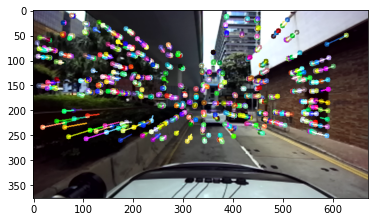

In [132]:
viz_tracks(px_ref, px_cur, last_data[0])

In [133]:
cur_R, cur_t

(array([[-0.00565636],
        [-0.01678137],
        [ 0.0077029 ]]),
 array([[-0.16697408],
        [-0.076136  ],
        [-2.90510588]]))

In [163]:
Vbdy = []
timestamp_v = []
last_data = (None, None, None, None, None, None)
FRAME_FLAG = 0
for t in tqdm(range(0, len(timestamp_l))):
    cur_R, cur_t, last_data = calc_VO(t, last_data)
    Vbdy.append(cur_t[:, 0])
    timestamp_v.append(timestamp_l[t])

  0%|          | 0/10000 [00:00<?, ?it/s]

motion_thresh  0.21365638766519823
motion_thresh  0.20344827586206896
motion_thresh  0.206436420722135
motion_thresh  0.2017751479289941
motion_thresh  0.2072588347659981
motion_thresh  0.21023181454836132
motion_thresh  0.2013745704467354
motion_thresh  0.2063397129186603
motion_thresh  0.20811240721102864
motion_thresh  0.21523003701745108
motion_thresh  0.19616204690831557
motion_thresh  0.19584885577434805
motion_thresh  0.19842105263157894
motion_thresh  0.19352290679304898
motion_thresh  0.18361433087460485
motion_thresh  0.1865671641791045
motion_thresh  0.18273841236014918
motion_thresh  0.18421052631578946
motion_thresh  0.17864693446088795
motion_thresh  0.17417815482502652
motion_thresh  0.17283298097251584
motion_thresh  0.17071881606765327
motion_thresh  0.17220464135021096
motion_thresh  0.17605263157894738
motion_thresh  0.17063492063492064
motion_thresh  0.17009493670886075
motion_thresh  0.17866458007303077
motion_thresh  0.16911764705882354
motion_thresh  0.1717678100

motion_thresh  3.227626459143969
motion_thresh  3.5550978372811533
motion_thresh  3.619068541300527
motion_thresh  3.6161495624502784
motion_thresh  3.423802612481858
motion_thresh  3.7916068866571018
motion_thresh  3.6784776902887137
motion_thresh  3.5978395061728397
motion_thresh  3.7895927601809953
motion_thresh  3.729591836734694
motion_thresh  3.455542382928275
motion_thresh  3.360263315380012
motion_thresh  3.3581201665675193
motion_thresh  3.134411947728687
motion_thresh  3.0516717325227964
motion_thresh  3.05771567436209
motion_thresh  2.8530510585305104
motion_thresh  2.7670419011882426
motion_thresh  2.7127054361567637
motion_thresh  2.741228070175439
motion_thresh  2.4762507916402785
motion_thresh  2.5766331658291457
motion_thresh  2.6935286935286937
motion_thresh  2.93811394891945
motion_thresh  3.042902208201893
motion_thresh  3.1115942028985506
motion_thresh  3.6053024645257654
motion_thresh  3.4580668088130775
motion_thresh  3.350852272727273
motion_thresh  3.19151846785

motion_thresh  0.20202020202020202
motion_thresh  0.2129979035639413
motion_thresh  0.20791032148900168
motion_thresh  0.21988205560235888
motion_thresh  0.2202928870292887
motion_thresh  0.2113380575239683
motion_thresh  0.1993228946254761
motion_thresh  0.1972187104930468
motion_thresh  0.2151477320016646
motion_thresh  0.19471053727613494
motion_thresh  0.19608659450457952
motion_thresh  0.1942490690939181
motion_thresh  0.18955472326258843
motion_thresh  0.1895615866388309
motion_thresh  0.1942821368948247
motion_thresh  0.19539748953974895
motion_thresh  0.18288590604026847
motion_thresh  0.19230769230769232
motion_thresh  0.1902800658978583
motion_thresh  0.19183422240459583
motion_thresh  0.19761709120788826
motion_thresh  0.20346677672307056
motion_thresh  0.2034764826175869
motion_thresh  0.19962993421052633
motion_thresh  0.18251661129568106
motion_thresh  0.18069514237855946
motion_thresh  0.18208702999577525
motion_thresh  0.18908629441624367
motion_thresh  0.19384288747346

motion_thresh  0.20029991431019709
motion_thresh  0.19365284974093264
motion_thresh  0.19647463456577816
motion_thresh  0.19423076923076923
motion_thresh  0.19319148936170213
motion_thresh  0.18528138528138527
motion_thresh  0.1903114186851211
motion_thresh  0.1847684984855041
motion_thresh  0.18615856329391153
motion_thresh  0.17533039647577092
motion_thresh  0.17204063604240283
motion_thresh  0.18239964711071902
motion_thresh  0.183547103051747
motion_thresh  0.18711385701676964
motion_thresh  0.1931868131868132
motion_thresh  0.20593330446080554
motion_thresh  0.2016059027777778
motion_thresh  0.2084233261339093
motion_thresh  0.21837088388214904
motion_thresh  0.20039249890972524
motion_thresh  0.20324675324675326
motion_thresh  0.19058976582827405
motion_thresh  0.18674438687392056
motion_thresh  0.18189730200174065
motion_thresh  0.17290126141800782
motion_thresh  0.17422279792746115
motion_thresh  0.17479320853286895
motion_thresh  0.17756804214223001
motion_thresh  0.1851770878

motion_thresh  0.7202208018593841
motion_thresh  0.6678121420389461
motion_thresh  0.6313441160066927
motion_thresh  0.6133260513380666
motion_thresh  0.6232914160743576
motion_thresh  0.5925827107790822
motion_thresh  0.5664556962025317
motion_thresh  0.5415577626764244
motion_thresh  0.4434895833333333
motion_thresh  0.4260204081632653
motion_thresh  0.40678824721377915
motion_thresh  0.40636042402826855
motion_thresh  0.3717171717171717
motion_thresh  0.33131923464249746
motion_thresh  0.2995449949443883
motion_thresh  0.2852760736196319
motion_thresh  0.28637770897832815
motion_thresh  0.28125
motion_thresh  0.28335056876938985
motion_thresh  0.2919916796671867
motion_thresh  0.25708397733127253
motion_thresh  0.26346053319393625
motion_thresh  0.28159126365054604
motion_thresh  0.2856772184743124
motion_thresh  0.29595494111623144
motion_thresh  0.3441971383147854
motion_thresh  0.3762480294272202
motion_thresh  0.4058885383806519
motion_thresh  0.4333507579717721
motion_thresh  0

motion_thresh  4.190763052208835
motion_thresh  4.055610236220472
motion_thresh  4.074183976261128
motion_thresh  4.296828543111992
motion_thresh  4.426879505664264
motion_thresh  4.065527065527066
motion_thresh  4.812972292191436
motion_thresh  4.835731414868105
motion_thresh  4.051008303677343
motion_thresh  3.8373563218390805
motion_thresh  3.797979797979798
motion_thresh  4.123633879781421
motion_thresh  4.444528875379939
motion_thresh  4.352825229960578
motion_thresh  4.6240126382306475
motion_thresh  4.555555555555555
motion_thresh  4.517523364485982
motion_thresh  4.45114006514658
motion_thresh  4.4526748971193415
motion_thresh  4.332474226804123
motion_thresh  4.03347280334728
motion_thresh  3.8883299798792756
motion_thresh  3.891932270916335
motion_thresh  3.707622298065984
motion_thresh  4.14431934493347
motion_thresh  3.8530876494023905
motion_thresh  3.7442528735632186
motion_thresh  4.152511961722488
motion_thresh  3.9857594936708862
motion_thresh  4.095755182625863
motion

motion_thresh  4.517213114754099
motion_thresh  4.395645028759244
motion_thresh  4.273679798826488
motion_thresh  4.298001737619462
motion_thresh  4.496157130657558
motion_thresh  4.839271255060729
motion_thresh  5.266927083333333
motion_thresh  5.531192660550459
motion_thresh  4.59479015918958
motion_thresh  3.7354260089686098
motion_thresh  3.688267394270123
motion_thresh  3.812579415501906
motion_thresh  3.7254237288135594
motion_thresh  3.7807881773399017
motion_thresh  3.7567567567567566
motion_thresh  3.6732418524871355
motion_thresh  3.7027877697841727
motion_thresh  3.7052364864864864
motion_thresh  3.7650602409638556
motion_thresh  3.694233687405159
motion_thresh  3.547479912344777
motion_thresh  3.5192170818505337
motion_thresh  3.5806338028169016
motion_thresh  3.4656140350877194
motion_thresh  3.376689189189189
motion_thresh  3.163816689466484
motion_thresh  3.2938144329896906
motion_thresh  3.3181506849315068
motion_thresh  3.5912642045454546
motion_thresh  3.9890226628895

motion_thresh  4.551040634291377
motion_thresh  4.7015075376884425
motion_thresh  4.109742441209407
motion_thresh  4.004540295119183
motion_thresh  3.501166861143524
motion_thresh  3.164009111617312
motion_thresh  3.1963503649635037
motion_thresh  3.6195795006570304
motion_thresh  3.5580075662042874
motion_thresh  3.424607961399276
motion_thresh  3.3493975903614457
motion_thresh  3.362250879249707
motion_thresh  3.257644394110985
motion_thresh  3.244774477447745
motion_thresh  3.305327868852459
motion_thresh  3.3396871945259043
motion_thresh  3.5024242424242424
motion_thresh  3.6561085972850678
motion_thresh  3.3511363636363636
motion_thresh  3.4406047516198703
motion_thresh  3.442099567099567
motion_thresh  3.5355626326963905
motion_thresh  2.959316037735849
motion_thresh  3.1128293241695304
motion_thresh  3.301341589267286
motion_thresh  3.1540755467196817
motion_thresh  3.4686013320647002
motion_thresh  4.255491329479769
motion_thresh  4.083684950773558
motion_thresh  4.106589147286

motion_thresh  0.16723901098901098
motion_thresh  0.16770508826583594
motion_thresh  0.16753562738964198
motion_thresh  0.17349439775910364
motion_thresh  0.1695095948827292
motion_thresh  0.16226818830242512
motion_thresh  0.1571632216678546
motion_thresh  0.16230272596843615
motion_thresh  0.15630582350839586
motion_thresh  0.1546813812744749
motion_thresh  0.155257586450247
motion_thresh  0.15174825174825174
motion_thresh  0.1592797783933518
motion_thresh  0.15637931034482758
motion_thresh  0.15413662890490903
motion_thresh  0.15283917035022102
motion_thresh  0.1515566199110503
motion_thresh  0.1492155525238745
motion_thresh  0.1498460485802258
motion_thresh  0.15514881970578173
motion_thresh  0.15959972862957938
motion_thresh  0.16213460231135282
motion_thresh  0.15153078775369797
motion_thresh  0.14501199862872816
motion_thresh  0.14543269230769232
motion_thresh  0.15322856166723609
motion_thresh  0.1630923555863023
motion_thresh  0.15158293186510668
motion_thresh  0.1598305084745

motion_thresh  0.1394279877425945
motion_thresh  0.14249320652173914
motion_thresh  0.14512855209742895
motion_thresh  0.15223930481283424
motion_thresh  0.15303080490228552
motion_thresh  0.1585244267198405
motion_thresh  0.16183816183816183
motion_thresh  0.157001647446458
motion_thresh  0.16283716283716285
motion_thresh  0.168099173553719
motion_thresh  0.15202254641909815
motion_thresh  0.1624876278455955
motion_thresh  0.16633366633366634
motion_thresh  0.13593854375417502
motion_thresh  0.14331210191082802
motion_thresh  0.14656616415410384
motion_thresh  0.13845895020188426
motion_thresh  0.13214525891055817
motion_thresh  0.13792522734927584
motion_thresh  0.14004078857919783
motion_thresh  0.1448087431693989
motion_thresh  0.15535470668485676
motion_thresh  0.15623937436246174
motion_thresh  0.15493679535360438
motion_thresh  0.13435667471541912
motion_thresh  0.13570691434468524
motion_thresh  0.13437393959959282
motion_thresh  0.1362402443162538
motion_thresh  0.131561008861

motion_thresh  0.12223781129428271
motion_thresh  0.12156043190525949
motion_thresh  0.1353840806395551
motion_thresh  0.12447698744769875
motion_thresh  0.1425275115370962
motion_thresh  0.16378378378378378
motion_thresh  0.14272890484739678
motion_thresh  0.16002870470039468
motion_thresh  0.15438533429187634
motion_thresh  0.16124954857349225
motion_thresh  0.17475192943770673
motion_thresh  0.18517165814463113
motion_thresh  0.19562861271676302
motion_thresh  0.16624134159679183
motion_thresh  0.16793478260869565
motion_thresh  0.18130874909616776
motion_thresh  0.17956099316300828
motion_thresh  0.2024029574861368
motion_thresh  0.20026178010471204
motion_thresh  0.19743299358248395
motion_thresh  0.21882172915072687
motion_thresh  0.28866178172001544
motion_thresh  0.32298897509187424
motion_thresh  0.31836569579288027
motion_thresh  0.30194676201827575
motion_thresh  0.31945556445156126
motion_thresh  0.3183838383838384
motion_thresh  0.325357873210634
motion_thresh  0.328080229

motion_thresh  3.876008064516129
motion_thresh  3.8298687089715537
motion_thresh  3.987424547283702
motion_thresh  3.6972386587771204
motion_thresh  3.62316715542522
motion_thresh  3.470967741935484
motion_thresh  3.5187445510026154
motion_thresh  3.5662358642972536
motion_thresh  3.727832512315271
motion_thresh  3.7870890136327184
motion_thresh  3.8732394366197185
motion_thresh  3.6075487012987013
motion_thresh  3.850383631713555
motion_thresh  4.148924731182795
motion_thresh  4.130089374379344
motion_thresh  4.164667896678967
motion_thresh  4.072844827586207
motion_thresh  3.9875215146299485
motion_thresh  4.16910229645094
motion_thresh  4.32887189292543
motion_thresh  4.507079646017699
motion_thresh  4.352791878172589
motion_thresh  4.354501607717042
motion_thresh  4.210848287112561
motion_thresh  4.213893249607535
motion_thresh  4.035317460317461
motion_thresh  4.075214341387373
motion_thresh  5.175925925925926
motion_thresh  4.995535714285714
motion_thresh  4.725168756027001
motio

motion_thresh  2.4154390100176784
motion_thresh  2.4054134443783464
motion_thresh  2.420281001832621
motion_thresh  2.354954954954955
motion_thresh  2.2584848484848483
motion_thresh  2.335030549898167
motion_thresh  2.383889238514789
motion_thresh  2.4034440344403443
motion_thresh  2.3369837296620775
motion_thresh  2.3140495867768593
motion_thresh  2.2625321336760926
motion_thresh  2.0414790996784564
motion_thresh  2.2441509433962263
motion_thresh  2.4780297661233166
motion_thresh  2.442556084296397
motion_thresh  2.513752455795678
motion_thresh  2.505122950819672
motion_thresh  2.366479269149684
motion_thresh  2.147120786516854
motion_thresh  2.1092553931802365
motion_thresh  2.262016021361816
motion_thresh  2.2158273381294964
motion_thresh  2.3309399477806787
motion_thresh  2.313380281690141
motion_thresh  2.3628125
motion_thresh  2.3727213541666665
motion_thresh  2.413978494623656
motion_thresh  2.450965250965251
motion_thresh  2.3706965572457968
motion_thresh  2.3725943033102386
mo

motion_thresh  1.130267214799589
motion_thresh  1.0910687405920723
motion_thresh  1.0556626506024096
motion_thresh  0.9524488825487399
motion_thresh  0.9113508442776735
motion_thresh  0.8065268065268065
motion_thresh  0.8381176470588235
motion_thresh  0.7130722038697499
motion_thresh  0.6610208816705336
motion_thresh  0.6266605588639487
motion_thresh  0.5708221626452189
motion_thresh  0.5860486461679669
motion_thresh  0.5354868061874432
motion_thresh  0.495583038869258
motion_thresh  0.44922547332185886
motion_thresh  0.4142312579415502
motion_thresh  0.38805031446540883
motion_thresh  0.34560965459841864
motion_thresh  0.3312193126022913
motion_thresh  0.3209901800327332
motion_thresh  0.26333734456478136
motion_thresh  0.25573902537253324
motion_thresh  0.24910465578989255
motion_thresh  0.2498048399687744
motion_thresh  0.23093302361595044
motion_thresh  0.2301678108314264
motion_thresh  0.21417769376181475
motion_thresh  0.21948488241881298
motion_thresh  0.20410082768999246
motion

motion_thresh  1.5993298228817616
motion_thresh  1.5491516966067864
motion_thresh  1.5326683291770573
motion_thresh  1.3661077235772359
motion_thresh  1.3654135338345865
motion_thresh  1.421820880752103
motion_thresh  1.434145129224652
motion_thresh  1.5566176470588236
motion_thresh  1.5915145535273805
motion_thresh  1.6198830409356726
motion_thresh  1.6078334159643035
motion_thresh  1.2287117903930131
motion_thresh  1.2312695109261187
motion_thresh  1.2522388059701492
motion_thresh  1.2541871921182266
motion_thresh  1.2520802741067059
motion_thresh  1.2531370656370657
motion_thresh  1.4577954319761668
motion_thresh  1.4775197628458498
motion_thresh  1.527915019762846
motion_thresh  1.4360991893180735
motion_thresh  1.440773949976404
motion_thresh  1.4526112185686655
motion_thresh  1.489263055148853
motion_thresh  1.5312035661218424
motion_thresh  1.782846715328467
motion_thresh  1.6683116883116884
motion_thresh  1.6840242669362993
motion_thresh  1.7096124811273277
motion_thresh  1.767

motion_thresh  3.860576923076923
motion_thresh  3.698186528497409
motion_thresh  3.6178543461237274
motion_thresh  3.28372591006424
motion_thresh  3.2226666666666666
motion_thresh  3.2296178343949045
motion_thresh  3.197062423500612
motion_thresh  3.325602409638554
motion_thresh  3.2990552325581395
motion_thresh  3.382213170400543
motion_thresh  3.477713178294574
motion_thresh  3.3830594184576483
motion_thresh  3.419076923076923
motion_thresh  3.8603801169590644
motion_thresh  4.008058608058608
motion_thresh  3.923076923076923
motion_thresh  3.9554421768707484
motion_thresh  3.3961617546264566
motion_thresh  3.6497844827586206
motion_thresh  3.5631830601092895
motion_thresh  3.858416547788873
motion_thresh  3.765
motion_thresh  3.4090616966580978
motion_thresh  3.3334335538184003
motion_thresh  3.267962308598351
motion_thresh  3.1281512605042017
motion_thresh  3.1265899454875834
motion_thresh  2.7099817407181983
motion_thresh  2.773557966876071
motion_thresh  3.082166768107121
motion_t

motion_thresh  0.11190932311621966
motion_thresh  0.11254019292604502
motion_thresh  0.10580980201233366
motion_thresh  0.10319767441860465
motion_thresh  0.10325911584382058
motion_thresh  0.10041976105908944
motion_thresh  0.0985237483953787
motion_thresh  0.099293059125964
motion_thresh  0.09827249022164276
motion_thresh  0.10006508298080052
motion_thresh  0.09735227639651275
motion_thresh  0.09581320450885668
motion_thresh  0.09515404364569961
motion_thresh  0.09252095422308189
motion_thresh  0.09514563106796116
motion_thresh  0.09833172922682067
motion_thresh  0.09690920798454604
motion_thresh  0.0960179833012203
motion_thresh  0.09650529015710163
motion_thresh  0.09580645161290323
motion_thresh  0.09767516951888924
motion_thresh  0.10019361084220717
motion_thresh  0.09568204121687929
motion_thresh  0.0982753010087862
motion_thresh  0.1000322684737012
motion_thresh  0.09794146027661628
motion_thresh  0.09938985228002568
motion_thresh  0.10012836970474968
motion_thresh  0.100545221

motion_thresh  1.6180820610687023
motion_thresh  1.5334581188582124
motion_thresh  1.5167224080267558
motion_thresh  1.4436215957955087
motion_thresh  1.4995274102079394
motion_thresh  1.5142071494042164
motion_thresh  1.4690346083788706
motion_thresh  1.563720930232558
motion_thresh  1.5763986835919135
motion_thresh  1.5487689393939394
motion_thresh  1.640223985067662
motion_thresh  1.5913953488372092
motion_thresh  1.5862539827036868
motion_thresh  1.529277218664227
motion_thresh  1.5580704160951075
motion_thresh  1.649080348499516
motion_thresh  1.6323456790123456
motion_thresh  1.7453634085213032
motion_thresh  1.7109725685785535
motion_thresh  1.7847188851513696
motion_thresh  1.737475442043222
motion_thresh  1.827706323687031
motion_thresh  2.0513992004568817
motion_thresh  2.0976757055893747
motion_thresh  2.0231326644370125
motion_thresh  1.9155953046394634
motion_thresh  1.9089906232763376
motion_thresh  1.9070021881838075
motion_thresh  1.796420581655481
motion_thresh  1.9039

motion_thresh  4.066916488222698
motion_thresh  4.3815653964984556
motion_thresh  4.392817679558011
motion_thresh  4.290878754171302
motion_thresh  3.940766550522648
motion_thresh  3.917588495575221
motion_thresh  4.0788876276958
motion_thresh  3.6470588235294117
motion_thresh  4.0072368421052635
motion_thresh  4.512534818941504
motion_thresh  4.497457627118644
motion_thresh  4.6835334476843915
motion_thresh  4.457685664939551
motion_thresh  4.935054773082942
motion_thresh  4.6546003016591255
motion_thresh  4.661961367013373
motion_thresh  3.564233576642336
motion_thresh  3.416173570019724
motion_thresh  3.730701754385965
motion_thresh  3.5038940809968846
motion_thresh  3.4451476793248945
motion_thresh  3.7972636815920398
motion_thresh  3.4468215158924207
motion_thresh  3.483050847457627
motion_thresh  3.6252631578947367
motion_thresh  3.7318045862412763
motion_thresh  3.2945301542777
motion_thresh  3.4073634204275534
motion_thresh  3.548317046688382
motion_thresh  3.814070351758794
mo

motion_thresh  2.646293375394322
motion_thresh  2.244020926756353
motion_thresh  1.9537102473498233
motion_thresh  1.9022556390977443
motion_thresh  1.8936170212765957
motion_thresh  1.8688778673279602
motion_thresh  1.812086590499098
motion_thresh  1.9337727558066542
motion_thresh  1.920012353304509
motion_thresh  1.8701413427561837
motion_thresh  1.7632177373507676
motion_thresh  1.7941816204458945
motion_thresh  1.7033531638723634
motion_thresh  1.7224284199363733
motion_thresh  1.7195876288659795
motion_thresh  1.7935684647302905
motion_thresh  1.6895734597156398
motion_thresh  1.6787012987012988
motion_thresh  1.6277749096541043
motion_thresh  1.5997952917093143
motion_thresh  1.5554981930820857
motion_thresh  1.506319514661274
motion_thresh  1.5666833166833167
motion_thresh  1.55730447614363
motion_thresh  1.5153508771929824
motion_thresh  1.4869477911646587
motion_thresh  1.480172852058973
motion_thresh  1.441831057157309
motion_thresh  1.7544474393530998
motion_thresh  1.884657

motion_thresh  4.1647727272727275
motion_thresh  4.019607843137255
motion_thresh  4.071571571571572
motion_thresh  4.0621442125237195
motion_thresh  4.390404929577465
motion_thresh  4.366148531951641
motion_thresh  4.2951448040885865
motion_thresh  4.412383177570093
motion_thresh  4.362068965517241
motion_thresh  4.677453027139875
motion_thresh  4.237118822292324
motion_thresh  3.870212765957447
motion_thresh  3.6794208893485005
motion_thresh  3.3982438016528924
motion_thresh  3.5953978906999042
motion_thresh  3.5798237022526935
motion_thresh  3.635869565217391
motion_thresh  3.505844845908608
motion_thresh  3.8985074626865672
motion_thresh  3.802987861811391
motion_thresh  3.856102003642987
motion_thresh  4.029109589041096
motion_thresh  4.244690674053555
motion_thresh  4.376258389261745
motion_thresh  4.178571428571429
motion_thresh  4.118305355715427
motion_thresh  4.184975767366721
motion_thresh  4.189919354838709
motion_thresh  4.182936507936508
motion_thresh  4.0701754385964914
m

motion_thresh  0.11707779886148008
motion_thresh  0.11999244142101285
motion_thresh  0.11542835481425322
motion_thresh  0.12027231467473525
motion_thresh  0.11733535200605602
motion_thresh  0.12022471910112359
motion_thresh  0.12700484893696382
motion_thresh  0.12574404761904762
motion_thresh  0.13253676470588235
motion_thresh  0.13157894736842105
motion_thresh  0.13448784082535004
motion_thresh  0.14711324944485565
motion_thresh  0.14833948339483394
motion_thresh  0.13088125466766243
motion_thresh  0.13024897807506503
motion_thresh  0.12744735869966753
motion_thresh  0.12094064949608063
motion_thresh  0.11763609246830724
motion_thresh  0.11583301993230538
motion_thresh  0.11345007451564829
motion_thresh  0.13686738086442557
motion_thresh  0.1327286190299889
motion_thresh  0.10901001112347053
motion_thresh  0.11127541589648798
motion_thresh  0.11335807050092764
motion_thresh  0.11639526276831977
motion_thresh  0.12181409295352325
motion_thresh  0.12696629213483146
motion_thresh  0.1322

motion_thresh  0.1512128325508607
motion_thresh  0.14499401675309134
motion_thresh  0.14495049504950494
motion_thresh  0.14511664689600634
motion_thresh  0.14771833202202989
motion_thresh  0.14580062794348508
motion_thresh  0.14237623762376236
motion_thresh  0.15092483274301455
motion_thresh  0.15481832543443919
motion_thresh  0.15402843601895735
motion_thresh  0.1564234734337827
motion_thresh  0.1514
motion_thresh  0.15337301587301588
motion_thresh  0.15645989727380483
motion_thresh  0.15340459224069675
motion_thresh  0.15524752475247525
motion_thresh  0.1487977926685061
motion_thresh  0.1462171697373579
motion_thresh  0.15001950838860711
motion_thresh  0.1469785575048733
motion_thresh  0.14982578397212543
motion_thresh  0.1472762645914397
motion_thresh  0.14801092043681746
motion_thresh  0.13782933543059378
motion_thresh  0.1259811616954474
motion_thresh  0.12358232303480642
motion_thresh  0.12087698874660457
motion_thresh  0.12386766443481685
motion_thresh  0.1199364575059571
motion

motion_thresh  0.11671243624950961
motion_thresh  0.11535448491970231
motion_thresh  0.11974872398900667
motion_thresh  0.12578125
motion_thresh  0.1239620403321471
motion_thresh  0.12573673870333987
motion_thresh  0.1249506514015002
motion_thresh  0.12583826429980277
motion_thresh  0.12593762337149625
motion_thresh  0.1308356218124755
motion_thresh  0.12926637897214593
motion_thresh  0.12568735271013354
motion_thresh  0.12534219788815018
motion_thresh  0.12295719844357976
motion_thresh  0.12248840803709428
motion_thresh  0.1250481695568401
motion_thresh  0.12988505747126436
motion_thresh  0.1295296838858905
motion_thresh  0.12819025522041763
motion_thresh  0.1298151001540832
motion_thresh  0.12978723404255318
motion_thresh  0.12906346749226005
motion_thresh  0.12925303089558077
motion_thresh  0.12893203883495147
motion_thresh  0.12850467289719625
motion_thresh  0.13031603589543503
motion_thresh  0.12879968823070928
motion_thresh  0.1318958818958819
motion_thresh  0.13171206225680934
m

motion_thresh  0.912259021255561
motion_thresh  0.9705434230573895
motion_thresh  1.044148380355277
motion_thresh  1.1293333333333333
motion_thresh  1.2125897294312535
motion_thresh  1.3500837520938023
motion_thresh  1.4040203850509627
motion_thresh  1.578229398663697
motion_thresh  1.5459272097053727
motion_thresh  1.5949656750572083
motion_thresh  1.732617297908423
motion_thresh  1.779128959276018
motion_thresh  1.899945770065076
motion_thresh  1.7706725468577729
motion_thresh  1.7984366275823562
motion_thresh  1.7226236798221235
motion_thresh  1.7976122797043774
motion_thresh  1.6316695352839932
motion_thresh  1.6977011494252874
motion_thresh  1.6391251518833536
motion_thresh  1.7308388654194327
motion_thresh  1.8338350391330525
motion_thresh  1.700792199878123
motion_thresh  1.516
motion_thresh  1.5229166666666667
motion_thresh  1.3046080191502094
motion_thresh  1.289319248826291
motion_thresh  1.3451149425287356
motion_thresh  1.7304550758459742
motion_thresh  1.7895785876993167
m

motion_thresh  4.1269942565411615
motion_thresh  3.718466898954704
motion_thresh  3.6927047487955953
motion_thresh  3.689972714870396
motion_thresh  3.5871186440677967
motion_thresh  3.8883097542814595
motion_thresh  3.919101924447612
motion_thresh  3.5579024034959943
motion_thresh  3.606367583212735
motion_thresh  3.383491599707816
motion_thresh  3.3767222625090647
motion_thresh  3.313124108416548
motion_thresh  3.2721914008321775
motion_thresh  3.2338995046001417
motion_thresh  3.0279593318809006
motion_thresh  2.941970802919708
motion_thresh  3.6277403035413154
motion_thresh  3.6497959183673467
motion_thresh  3.6157222665602555
motion_thresh  3.7415437987857763
motion_thresh  3.6557377049180326
motion_thresh  3.3191659983961506
motion_thresh  3.2805255023183926
motion_thresh  3.2054945054945057
motion_thresh  3.1688048615800133
motion_thresh  3.010177281680893
motion_thresh  3.132552404438964
motion_thresh  3.33240611961057
motion_thresh  3.3687171792948236
motion_thresh  3.63324979

motion_thresh  4.713143872113677
motion_thresh  4.241883116883117
motion_thresh  5.074773413897281
motion_thresh  5.572741194486984
motion_thresh  4.690225563909775
motion_thresh  4.803442028985507
motion_thresh  5.26646248085758
motion_thresh  5.191062176165803
motion_thresh  5.779883381924198
motion_thresh  5.322953736654804
motion_thresh  4.616815476190476
motion_thresh  4.197033898305085
motion_thresh  3.800657894736842
motion_thresh  4.155122655122655
motion_thresh  4.079719387755102
motion_thresh  3.87227602905569
motion_thresh  3.4988425925925926
motion_thresh  3.8837555886736213
motion_thresh  3.99875
motion_thresh  3.989977728285078
motion_thresh  3.7291880781089413
motion_thresh  3.4595404595404595
motion_thresh  3.2427140255009106
motion_thresh  3.152753108348135
motion_thresh  3.0081685296646605
motion_thresh  2.8476112026359144
motion_thresh  2.575059571088165
motion_thresh  2.6792750197005515
motion_thresh  2.6759474091260635
motion_thresh  2.6887235708692248
motion_thres

motion_thresh  0.6699414715719063
motion_thresh  0.6175979983319433
motion_thresh  0.5821946169772256
motion_thresh  0.5508543531326282
motion_thresh  0.537379421221865
motion_thresh  0.5019554165037153
motion_thresh  0.4385998469778118
motion_thresh  0.417298937784522
motion_thresh  0.3144916540212443
motion_thresh  0.2896692679301375
motion_thresh  0.26572385560104206
motion_thresh  0.25583982202447164
motion_thresh  0.2384558551902475
motion_thresh  0.19170033051781124
motion_thresh  0.17477148080438756
motion_thresh  0.16703176341730558
motion_thresh  0.1617701065001836
motion_thresh  0.16197704553868938
motion_thresh  0.17047583364556013
motion_thresh  0.1784771956275914
motion_thresh  0.18192005976839745
motion_thresh  0.19088531938737394
motion_thresh  0.1940665154950869
motion_thresh  0.20775462962962962
motion_thresh  0.22411787514540518
motion_thresh  0.253757225433526
motion_thresh  0.2702127659574468
motion_thresh  0.2760989010989011
motion_thresh  0.28262610088070456
motio

motion_thresh  4.395069532237674
motion_thresh  4.2770562770562774
motion_thresh  4.368926553672316
motion_thresh  5.094818081587651
motion_thresh  4.487073422957601
motion_thresh  3.9278937381404173
motion_thresh  3.8970873786407765
motion_thresh  4.318096135721018
motion_thresh  3.968430034129693
motion_thresh  3.5932270916334663
motion_thresh  3.67172593235039
motion_thresh  3.524855012427506
motion_thresh  3.3715524034672972
motion_thresh  3.1613515565679573
motion_thresh  3.1805349182763742
motion_thresh  3.1883358098068353
motion_thresh  3.2129765395894427
motion_thresh  3.219266714593817
motion_thresh  2.9920920201294035
motion_thresh  3.038434414668547
motion_thresh  3.0763358778625953
motion_thresh  3.227835051546392
motion_thresh  3.7396657871591907
motion_thresh  4.681538461538461
motion_thresh  5.0322128851540615
motion_thresh  5.082228116710875
motion_thresh  5.049388111888112
motion_thresh  5.669005847953216
motion_thresh  5.654171066525871
motion_thresh  5.85728848114169

motion_thresh  1.1321656050955413
motion_thresh  1.0391604010025062
motion_thresh  0.9769425142135186
motion_thresh  0.941418619379354
motion_thresh  1.213406292749658
motion_thresh  1.138830162085976
motion_thresh  1.1479697178251893
motion_thresh  1.297372060857538
motion_thresh  1.2758734344100198
motion_thresh  1.2424522489217498
motion_thresh  1.1640304628002343
motion_thresh  1.1227096057745696
motion_thresh  1.0801195002715915
motion_thresh  0.978283621140764
motion_thresh  0.8849716932578486
motion_thresh  0.8665158371040724
motion_thresh  0.7194513715710723
motion_thresh  0.6819351518270715
motion_thresh  0.6568077511473738
motion_thresh  0.6568527918781726
motion_thresh  0.6531172069825436
motion_thresh  0.6016823354774864
motion_thresh  0.5684760956175299
motion_thresh  0.5399899396378269
motion_thresh  0.5110078277886497
motion_thresh  0.5186960690316395
motion_thresh  0.48370086289549374
motion_thresh  0.45266698702546854
motion_thresh  0.42567567567567566
motion_thresh  0

motion_thresh  0.1436123348017621
motion_thresh  0.14323490524460114
motion_thresh  0.1378627968337731
motion_thresh  0.13020372010628875
motion_thresh  0.13731609451627286
motion_thresh  0.14343343792021515
motion_thresh  0.13986486486486485
motion_thresh  0.14253597122302158
motion_thresh  0.13745471014492755
motion_thresh  0.1401911697769686
motion_thresh  0.1392174704276615
motion_thresh  0.1411764705882353
motion_thresh  0.1474820143884892
motion_thresh  0.14779313419527418
motion_thresh  0.14788732394366197
motion_thresh  0.1414351851851852
motion_thresh  0.12610929472209248
motion_thresh  0.1302717900656045
motion_thresh  0.12401300510915002
motion_thresh  0.12413474850023073
motion_thresh  0.12615526802218113
motion_thresh  0.12005583992554676
motion_thresh  0.12224770642201835
motion_thresh  0.13137697516930022
motion_thresh  0.1329596412556054
motion_thresh  0.13203753351206435
motion_thresh  0.12896028558679162
motion_thresh  0.12577639751552794
motion_thresh  0.122779751332

motion_thresh  2.0735400144196108
motion_thresh  2.0804638088545326
motion_thresh  2.0455465587044532
motion_thresh  2.015532055518837
motion_thresh  1.9296551724137931
motion_thresh  2.0861358956760467
motion_thresh  2.226896551724138
motion_thresh  2.1468336812804454
motion_thresh  2.097796143250689
motion_thresh  2.240160106737825
motion_thresh  2.221056194989844
motion_thresh  2.193390052356021
motion_thresh  2.6899166034874904
motion_thresh  2.412549019607843
motion_thresh  2.2373511904761907
motion_thresh  2.114193083573487
motion_thresh  2.249828414550446
motion_thresh  2.151911468812877
motion_thresh  2.273523685918235
motion_thresh  2.1690095846645367
motion_thresh  2.170660621761658
motion_thresh  2.068381855111713
motion_thresh  2.124914207275223
motion_thresh  2.0892370572207084
motion_thresh  2.0042134831460676
motion_thresh  2.200353356890459
motion_thresh  2.080158159597412
motion_thresh  2.1577464788732392
motion_thresh  2.1999309392265194
motion_thresh  2.2669098143236

motion_thresh  3.7880094043887147
motion_thresh  4.152100840336135
motion_thresh  4.056003223207091
motion_thresh  3.9783634933123526
motion_thresh  4.322533849129594
motion_thresh  3.9504906333630685
motion_thresh  3.959016393442623
motion_thresh  3.8034154090548054
motion_thresh  3.6858540255831453
motion_thresh  3.4781319495922904
motion_thresh  3.4516728624535316
motion_thresh  3.3623452294246174
motion_thresh  3.3396564065855405
motion_thresh  3.0822072072072073
motion_thresh  3.0057049714751427
motion_thresh  3.1278688524590166
motion_thresh  3.677281368821293
motion_thresh  3.960852329038652
motion_thresh  3.7783985102420856
motion_thresh  3.58018018018018
motion_thresh  3.968045112781955
motion_thresh  3.818100358422939
motion_thresh  4.252752293577982
motion_thresh  4.630600571973308
motion_thresh  4.466816143497758
motion_thresh  4.751020408163265
motion_thresh  4.47093023255814
motion_thresh  4.094174757281554
motion_thresh  3.9948015122873346
motion_thresh  4.07404181184669

motion_thresh  3.8224893917963225
motion_thresh  3.8639755766621438
motion_thresh  3.7646103896103895
motion_thresh  3.8674582798459562
motion_thresh  3.97141041931385
motion_thresh  3.9048982188295165
motion_thresh  3.9700386597938144
motion_thresh  3.7870189171559034
motion_thresh  3.8902439024390243
motion_thresh  4.039561487130601
motion_thresh  4.099437148217636
motion_thresh  4.103188662533215
motion_thresh  3.721529509559435
motion_thresh  4.265849535080305
motion_thresh  4.344483058210252
motion_thresh  4.246978243352135
motion_thresh  4.080693815987933
motion_thresh  3.7986694677871147
motion_thresh  3.7098806366047747
motion_thresh  3.7286821705426356
motion_thresh  4.046137339055794
motion_thresh  4.01850627891606
motion_thresh  4.095046439628483
motion_thresh  3.9384422110552766
motion_thresh  4.100129198966409
motion_thresh  4.163198959687906
motion_thresh  4.371951219512195
motion_thresh  4.443153266331659
motion_thresh  4.475292587776333
motion_thresh  4.325895875591616


motion_thresh  0.14245416078984485
motion_thresh  0.14715245843650512
motion_thresh  0.1403106247793858
motion_thresh  0.13477041710480198
motion_thresh  0.13590192644483362
motion_thresh  0.13778966131907308
motion_thresh  0.13336933045356372
motion_thresh  0.13948033201010465
motion_thresh  0.17920115149334293
motion_thresh  0.19989067055393586
motion_thresh  0.23076923076923078
motion_thresh  0.3057336854017352
motion_thresh  0.29458109146810146
motion_thresh  0.3198698315467075
motion_thresh  0.360260336906585
motion_thresh  0.39949942241047365
motion_thresh  0.447869101978691
motion_thresh  0.44081237911025145
motion_thresh  0.5066640533124265
motion_thresh  0.48545025560361776
motion_thresh  0.43164904034469254
motion_thresh  0.4440993788819876
motion_thresh  0.4579799537393986
motion_thresh  0.4070624757469926
motion_thresh  0.456641702798581
motion_thresh  0.46645367412140576
motion_thresh  0.5083741830065359
motion_thresh  0.5737571312143439
motion_thresh  0.6076178960096735
m

motion_thresh  4.757757757757758
motion_thresh  4.733546617915905
motion_thresh  4.933695652173913
motion_thresh  4.598214285714286
motion_thresh  4.259103641456583
motion_thresh  4.368122270742358
motion_thresh  3.93448275862069
motion_thresh  4.128903122497999
motion_thresh  4.114307931570762
motion_thresh  4.102229054573405
motion_thresh  3.85202492211838
motion_thresh  3.715970961887477
motion_thresh  3.7261904761904763
motion_thresh  3.76625386996904
motion_thresh  3.7464042392127177
motion_thresh  3.719178082191781
motion_thresh  3.7611764705882353
motion_thresh  3.7026143790849675
motion_thresh  3.4408906882591093
motion_thresh  3.263488543976349
motion_thresh  3.5248194945848375
motion_thresh  3.5390893470790377
motion_thresh  3.481922760887428
motion_thresh  3.3458367683429513
motion_thresh  3.3499210110584516
motion_thresh  3.3486238532110093
motion_thresh  3.3453453453453452
motion_thresh  3.701010101010101
motion_thresh  3.8616619452313503
motion_thresh  3.730804387568556
m

motion_thresh  0.5499543795620438
motion_thresh  0.5202702702702703
motion_thresh  0.513351134846462
motion_thresh  0.4745762711864407
motion_thresh  0.43638392857142855
motion_thresh  0.4416025350837483
motion_thresh  0.4083594099240054
motion_thresh  0.38046910239061793
motion_thresh  0.3651359786000892
motion_thresh  0.33056925145674587
motion_thresh  0.3453887884267631
motion_thresh  0.33520431073192636
motion_thresh  0.336996336996337
motion_thresh  0.3382079851439183
motion_thresh  0.31129032258064515
motion_thresh  0.336117381489842
motion_thresh  0.3336363636363636
motion_thresh  0.3174496644295302
motion_thresh  0.29901079136690645
motion_thresh  0.26258503401360545
motion_thresh  0.2808683853459973
motion_thresh  0.2418552036199095
motion_thresh  0.23864648263579696
motion_thresh  0.20747252747252748
motion_thresh  0.20585645090268603
motion_thresh  0.21495956873315364
motion_thresh  0.25716886663632227
motion_thresh  0.3358070500927644
motion_thresh  0.49042503503035967
moti

motion_thresh  1.5978898007033997
motion_thresh  1.5638359329867129
motion_thresh  1.5070861678004535
motion_thresh  1.5072992700729928
motion_thresh  1.4206744057490326
motion_thresh  1.5151169423844837
motion_thresh  1.4510192525481314
motion_thresh  1.4173716864072194
motion_thresh  1.363888888888889
motion_thresh  1.3206644144144144
motion_thresh  1.3690140845070422
motion_thresh  1.3435547984099943
motion_thresh  1.3478753541076487
motion_thresh  1.3576662908680948
motion_thresh  1.2954545454545454
motion_thresh  1.268107476635514
motion_thresh  1.2117612977983778
motion_thresh  1.2227582292849035
motion_thresh  1.2179988820570151
motion_thresh  1.2110795454545455
motion_thresh  1.2
motion_thresh  1.2036830357142858
motion_thresh  1.184517203107658
motion_thresh  1.1448957189901208
motion_thresh  1.2134376686454398
motion_thresh  1.4342105263157894
motion_thresh  1.4864864864864864
motion_thresh  1.6075581395348837
motion_thresh  1.6544823906083244
motion_thresh  1.636015325670498

motion_thresh  3.7808340727595384
motion_thresh  3.923908149482215
motion_thresh  3.996845425867508
motion_thresh  4.1150265957446805
motion_thresh  4.2044849023090585
motion_thresh  4.2341001353179974
motion_thresh  4.1824545030331315
motion_thresh  4.236258660508083
motion_thresh  4.2709573980760425
motion_thresh  4.224296911018903
motion_thresh  4.075141776937619
motion_thresh  4.03698296836983
motion_thresh  4.015861395802831
motion_thresh  4.018536121673004
motion_thresh  4.694099378881988
motion_thresh  4.533536585365853
motion_thresh  4.4538386783284745
motion_thresh  4.554330285099516
motion_thresh  4.3883442265795205
motion_thresh  4.091263216471898
motion_thresh  3.7840973401245046
motion_thresh  3.635135135135135
motion_thresh  3.4358608893956673
motion_thresh  3.2007874015748032
motion_thresh  3.0836653386454183
motion_thresh  2.964190093708166
motion_thresh  2.6470394736842104
motion_thresh  2.538061158100195
motion_thresh  2.6050214329454993
motion_thresh  2.5461077844311

motion_thresh  3.4769926047658175
motion_thresh  3.3517156862745097
motion_thresh  3.397942386831276
motion_thresh  3.312905844155844
motion_thresh  3.3947157726180945
motion_thresh  3.3923582580115035
motion_thresh  3.246166950596252
motion_thresh  3.5483558994197293
motion_thresh  3.6237579042457093
motion_thresh  3.814658803706824
motion_thresh  3.464123524069028
motion_thresh  3.2367194780987885
motion_thresh  2.932104752667313
motion_thresh  2.977121067683508
motion_thresh  3.029918404351768
motion_thresh  3.132792485055508
motion_thresh  2.929123711340206
motion_thresh  3.1810490693739424
motion_thresh  3.043572044866264
motion_thresh  2.8012875536480686
motion_thresh  3.0681632653061226
motion_thresh  2.9577950043066323
motion_thresh  2.942156003505697
motion_thresh  2.9302226027397262
motion_thresh  3.014932562620424
motion_thresh  3.265566037735849
motion_thresh  3.247100802854594
motion_thresh  3.447635135135135
motion_thresh  3.3529166666666668
motion_thresh  3.4370078740157

motion_thresh  1.9713302752293578
motion_thresh  1.9929328621908127
motion_thresh  1.9832650273224044
motion_thresh  2.0365771812080538
motion_thresh  2.1443798449612403
motion_thresh  2.127809890815671
motion_thresh  2.1122059758423393
motion_thresh  2.256394640682095
motion_thresh  2.2813084112149533
motion_thresh  2.409035409035409
motion_thresh  2.482317073170732
motion_thresh  2.635692307692308
motion_thresh  2.4967679379444085
motion_thresh  2.534313725490196
motion_thresh  2.5565729234793984
motion_thresh  2.429847782925215
motion_thresh  2.571151358344114
motion_thresh  2.621782178217822
motion_thresh  2.543192812715964
motion_thresh  2.8263598326359833
motion_thresh  2.745925925925926
motion_thresh  2.9008142116950406
motion_thresh  2.9658703071672354
motion_thresh  3.1251025430680888
motion_thresh  3.086248012718601
motion_thresh  2.460434782608696
motion_thresh  2.5453345070422535
motion_thresh  2.645004061738424
motion_thresh  2.5952023988005997
motion_thresh  2.50972897845

motion_thresh  1.348955223880597
motion_thresh  1.1925338036449147
motion_thresh  0.979806598407281
motion_thresh  0.9123340707964602
motion_thresh  0.763978494623656
motion_thresh  0.6643617021276595
motion_thresh  0.5143080124869928
motion_thresh  0.4642137096774194
motion_thresh  0.4058394160583942


In [164]:
Vbdy = np.array(Vbdy)
Vbdy.shape

(10000, 3)

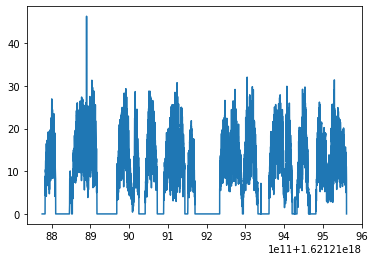

In [169]:
plt.plot(timestamp_v, np.linalg.norm(Vbdy, axis=1))
# plt.ylim([0, 20])

In [166]:
V_rotated = np.linalg.inv(H_l[:3, :3]) @ Vbdy.T

In [167]:
1/np.mean(np.diff(timestamp_v, 1)/1e9)

12.73103186264738

In [168]:
np.save("/oak/stanford/groups/gracegao/HKdataset/data_06_22_22/velocity_vo_15Hz.npy", V_rotated)
np.save("/oak/stanford/groups/gracegao/HKdataset/data_06_22_22/velocity_vo_15Hz_timestamp.npy", np.array(timestamp_v))